In [0]:
!pip -q install torch torchvision
!pip -q install Pillow==4.0.0

# for neuro audio style Transfer
!pip install librosa
!apt-get install ffmpeg

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import optim
from torchvision import datasets , transforms , models
from torch import nn

from PIL import Image, ImageFilter, ImageChops
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# [Style Transfer](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
Style transfer is damn easy and cool application to work on. It let's you generate artistic images.

So In plain english it takes two images **A Content  Image** and **A Style Image** and transfers the style to the content image.

![](https://datascience-enthusiast.com/figures/louvre_generated.png)

It uses pretained CNN model as a feature extractor that can separate and recombine the imagec ontent and style of natural images.

The algorithm allows  to produce new images of high perceptual quality that combine the content of an arbitrary photograph with the appearance of numerous well known artworks. 

### The most interesting thing about style transfer from my perspective is
1.  Super easy to implement
2. The reasearch paper is full of images and explanation is given in simple terms so a good starting point into reading reasearch paper.
3. Uses VGG16 network which is again easy to deal with.
4. Lot's of online tool to play around. https://deepart.io/#
5. Helps to get deeper understanding of CNNs.

In [7]:
# get the data 
!wget -q https://newevolutiondesigns.com/images/freebies/retro-wallpaper-35.jpg
!wget -q https://stmed.net/sites/default/files/tropical-wallpapers-28081-3502163.jpg
!wget -q https://assets.saatchiart.com/saatchi/698294/art/3752639/2822523-XBYPURAP-32.jpg
!mv retro-wallpaper-35.jpg deepDreamImage.jpg
!mv 2822523-XBYPURAP-32.jpg style.jpg
!mv tropical-wallpapers-28081-3502163.jpg content.jpg
!ls

content.jpg  deepDreamImage.jpg  sample_data  style.jpg


## Note :- Here the notebook for style transfer is written in a way that it only works for a single image at a time

In [0]:
#Imagenet mean and std to normalize the image with 
mean = np.array((0.485, 0.456, 0.406))
std = np.array((0.229, 0.224, 0.225))


In [0]:
def convert_Tensor(imgORpath , size):
  """I takes an PIL image or an Image path converts it in RGB and resizes it and return a normalized tensor image
      Arguments:
        imgORpath : either a pil image or an Image path
        size : the size of the final image
        shape: optional but the 
  """
  #load the image 
  
  if isinstance(imgORpath ,Path):
    image = Image.open(imgORpath)
  else:
    image = imgORpath
  image = image.convert("RGB")

  
  # some transformation
  transform = transforms.Compose([transforms.Resize(size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std) ])
  
  # increase the dimension for batch size=1
  image = transform(image).unsqueeze(dim=0)
  return image
      
content = convert_Tensor(Path("content.jpg") , size=(1000,1000)).to(device)
style = convert_Tensor(Path("style.jpg") , size=(600,600)).to(device)

In [0]:
# Actually pytorch use channel first format but matplotlib uses channel last format
def denormalize(image):
  image = image.clone().detach().to("cpu")   # first clone the image and detach it and then transfer it to cpu 
  image = image.squeeze(0).numpy() #squeeze the extra single batch dimension and convert to numpy
  image = np.transpose(image , (1,2,0)) # swap the channels to bring channel to last
  image = image * std+mean # denormalize to get original image
  image = np.clip(image, 0,1) # clip all the values between 0 and 1 
  return image


Text(0.5, 1.0, 'style image')

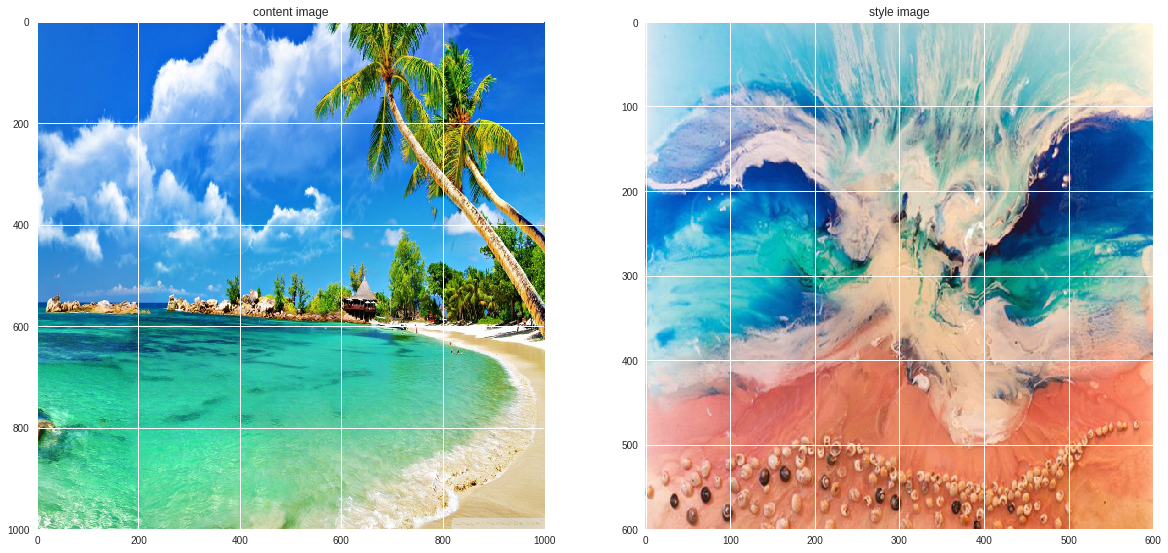

In [23]:
fig ,(ax1 , ax2) = plt.subplots(1,2 , figsize=(20,20))
ax1.imshow(denormalize(content))
ax1.set_title("content image")
ax2.imshow(denormalize(style))
ax2.set_title("style image")

In [0]:
# import model feature and load to gpu
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for x in vgg.parameters():
  x.requires_grad_(False)


 ## Vgg Architecutre
![](https://proxy.duckduckgo.com/iu/?u=http%3A%2F%2Fimage.slidesharecdn.com%2Fdeeplearningclass2-louismonier-160501185826%2F95%2Fdeep-learning-class-2-deep-learning-for-images-i-see-what-you-mean-12-638.jpg%3Fcb%3D1462253453&f=1)
  

As described in the paper:

we extract the style of the first convolution layer from each block 
1. conv1_1
2. conv2_1 
3. conv3_1
4. conv4_1
5. conv5_1

We do this because at different layer cnn gives different kinds of feature map from simple to complex features and we want to use all of those.
This creates images that match the style of a given image on an increasing scale while discarding information of the global arrangement of the scene.

For Content extraction we use the 2nd layer of forth block
1. conv4_2

Actually we can use any layer from any block for content and style extraction but this typical layers configuration  gave good results.



In [75]:
#style block
style_blocks=[0]
style_blocks.extend([i+1 for i , layer in enumerate(vgg) if isinstance(layer , nn.MaxPool2d) and i+1 < len(vgg)])
print(style_blocks)

#content block so the 
content_blocks = [21]

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
      self.features = output
      self.hook.remove()
      
def load_features(images,model , blocks ):
  ef = [SaveFeatures(model[block]) for block in blocks]
  model(images)
  return ef
  
content_features = load_features(content , vgg , content_blocks)
style_features = load_features(style , vgg , style_blocks)



[0, 5, 10, 19, 28]


In [76]:
[x.features.shape for x in style_features]

[torch.Size([1, 64, 600, 600]),
 torch.Size([1, 128, 300, 300]),
 torch.Size([1, 256, 150, 150]),
 torch.Size([1, 512, 75, 75]),
 torch.Size([1, 512, 37, 37])]

In [77]:
[x.features.shape for x in content_features]

[torch.Size([1, 512, 125, 125])]

In [0]:
def gram_matrix(t_tensor):
  c,d,h,w = t_tensor.shape
  tensor = t_tensor.view(d,w*h)
  tensor = torch.mm(tensor , tensor.t())
  return tensor.div(c*d*h*w)

style_gram_matrix = [gram_matrix(layer.features) for layer in style_features]

target = content.clone().requires_grad_(True).to(device)

In [79]:
style_gram_matrix

[tensor([[0.0063, 0.0026, 0.0024,  ..., 0.0062, 0.0015, 0.0034],
         [0.0026, 0.0074, 0.0025,  ..., 0.0049, 0.0014, 0.0037],
         [0.0024, 0.0025, 0.0066,  ..., 0.0001, 0.0021, 0.0033],
         ...,
         [0.0062, 0.0049, 0.0001,  ..., 0.0411, 0.0037, 0.0064],
         [0.0015, 0.0014, 0.0021,  ..., 0.0037, 0.0018, 0.0019],
         [0.0034, 0.0037, 0.0033,  ..., 0.0064, 0.0019, 0.0055]],
        device='cuda:0'),
 tensor([[0.0273, 0.0008, 0.0099,  ..., 0.0091, 0.0040, 0.0105],
         [0.0008, 0.0027, 0.0010,  ..., 0.0048, 0.0018, 0.0008],
         [0.0099, 0.0010, 0.0135,  ..., 0.0047, 0.0019, 0.0058],
         ...,
         [0.0091, 0.0048, 0.0047,  ..., 0.0464, 0.0130, 0.0059],
         [0.0040, 0.0018, 0.0019,  ..., 0.0130, 0.0199, 0.0102],
         [0.0105, 0.0008, 0.0058,  ..., 0.0059, 0.0102, 0.0206]],
        device='cuda:0'),
 tensor([[0.0196, 0.0060, 0.0016,  ..., 0.0041, 0.0043, 0.0051],
         [0.0060, 0.0506, 0.0170,  ..., 0.0111, 0.0058, 0.0120],
        

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = (1.,0.75,0.5,0.5,0.2)

content_weight = 1  # alpha
style_weight = 2e7  # beta

  0%|          | 0/2000 [00:00<?, ?it/s]

Total loss  is 860.6051635742188 style loss 4.3030257074860856e-05 content loss 0.0


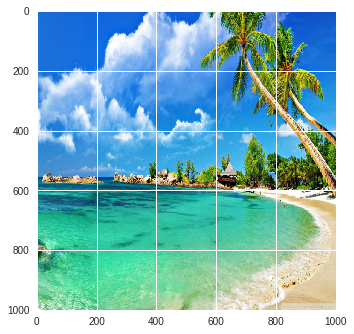

 20%|██        | 400/2000 [07:48<31:13,  1.17s/it]

Total loss  is 27.13860511779785 style loss 1.169216830021469e-06 content loss 3.7542693614959717


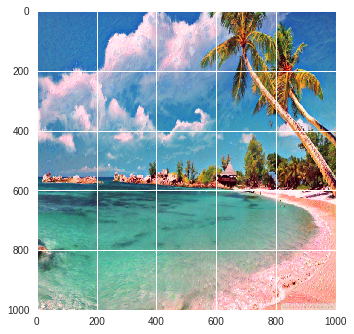

 40%|████      | 800/2000 [15:37<23:25,  1.17s/it]

Total loss  is 13.93302059173584 style loss 5.230401711742161e-07 content loss 3.472217559814453


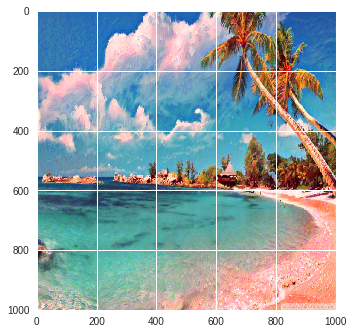

 60%|██████    | 1200/2000 [23:25<15:37,  1.17s/it]

Total loss  is 9.457903861999512 style loss 3.076045231864555e-07 content loss 3.3058135509490967


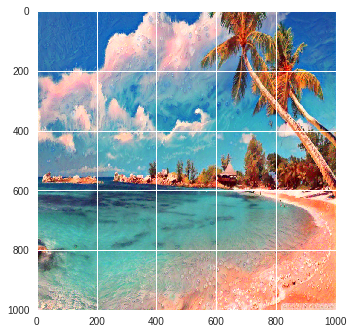

 80%|████████  | 1600/2000 [31:14<07:48,  1.17s/it]

Total loss  is 7.3580098152160645 style loss 2.0914653475756495e-07 content loss 3.175079345703125


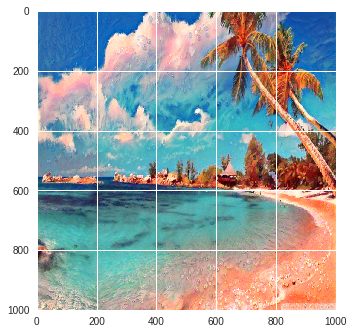

100%|██████████| 2000/2000 [39:04<00:00,  1.17s/it]


In [81]:

optimizer = optim.Adam([target] , lr=0.005)

epoch=2000
each_step=400

for each_epoch in tqdm(range(epoch)):
  
  optimizer.zero_grad()
  
  target_features  = load_features(target , vgg, style_blocks+content_blocks)
  
  content_loss = F.mse_loss(target_features[-1].features,content_features[0].features)
  style_loss = 0
  
  for layer ,sty_gram, weights in zip(target_features[:-1] , style_gram_matrix,style_weights):
    target_tensor = gram_matrix(layer.features)
    layer_style_loss = weights * F.mse_loss(target_tensor ,sty_gram)
    style_loss += layer_style_loss
    
  total_loss = content_weight*content_loss + style_weight*style_loss
  total_loss.backward()
  optimizer.step()
  if each_epoch % each_step==0:
    print(f"Total loss  is {total_loss.item()} style loss {style_loss.item()} content loss {content_loss.item()}")
    plt.imshow(denormalize(target))
    plt.show()

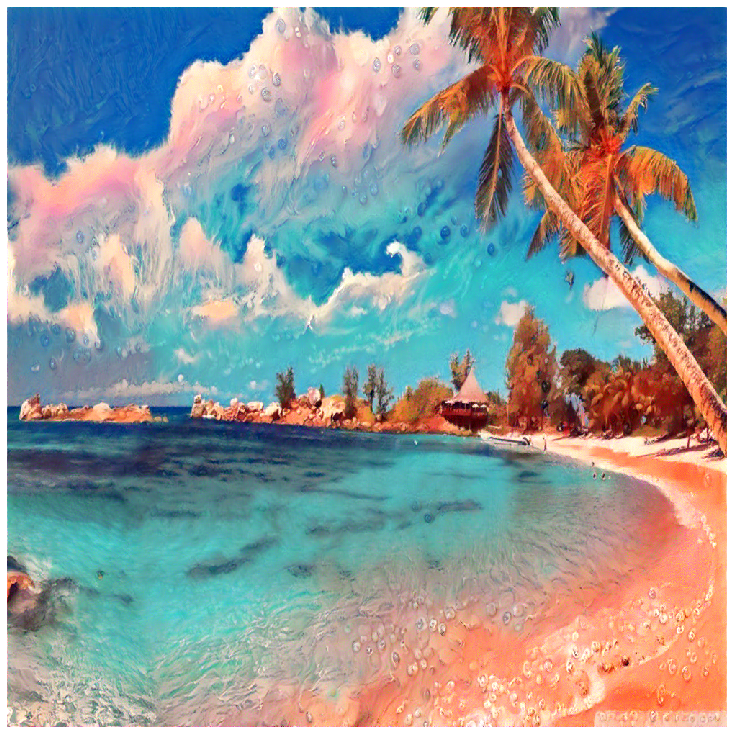

In [83]:
def save(filepath, fig=None):
    '''Save the current image with no whitespace
    Example filepath: "myfig.png" or r"C:\myfig.pdf" 
    '''
    if not fig:
        fig = plt.gcf()

    plt.subplots_adjust(0,0,1,1,0,0)
    for ax in fig.axes:
        ax.axis('off')
        ax.margins(0,0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(filepath, pad_inches = 0, bbox_inches='tight')
    
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(denormalize(target))
save("finalResult.jpg")


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
#!cp gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!cp finalResult.jpg gdrive/My\ Drive/

In [0]:
!rm finalResult.jpg finalResult1.jpg

# Deep Dream
![](https://cdn-images-1.medium.com/max/800/1*SFgIqRXLDE03_sUWNnxFzQ.png)

In [0]:
#constants
IMAGE_PATH = Path("deepDreamImage.jpg") # The path of the image on which deep dream algo has to be executed
LAYER_ID = 28 #Which layers activation you want to be maximized 
NUM_ITERATIONS=5 #No of iterations to update the  image with gradients 
LR=0.2  

# Here the original image is downsampled recursevly by half of the size and then a temporary image is generated using deep dream algo 
# which is then scaled up and blended with the original image
NUM_DOWNSCALES=20
BLEND_ALPHA=0.6
# The image size
SIZE=(600,600)


In [0]:
image = Image.open(IMAGE_PATH).resize(SIZE) 
model = models.vgg16(pretrained=True).to(device)
moduleList = list(model.features.modules())


In [0]:
def deepDream(image,layer,iteration,lr): #here image is a pil image
    input = convert_Tensor(image,shape=SIZE).to(device).requires_grad_(True)
    for _ in range(iteration):
      model.zero_grad()
      out=input
      for i in range(layer):
        out = moduleList[i+1](out)
      loss = out.norm()
      loss.backward()
      input.data = input.data + lr *input.grad.data
    
    denorm = denormalize(input.data)
    return Image.fromarray(np.uint8(denorm*255)) # return a pil image

In [0]:
def deepDreamRecursive(image,layer=LAYER_ID,iteration=NUM_ITERATIONS,lr=LR,num_downscales=NUM_DOWNSCALES):
    if num_downscales>0:

      image_small = image.filter(ImageFilter.GaussianBlur(2))
      small_size = (int(image_small.size[0]/2), int(image_small.size[1]/2))
      
      if (small_size[0] < 1 or small_size[1] < 1):
        small_size = image_small.size      
      
      image_small = image_small.resize(small_size,Image.ANTIALIAS)
      
      image_small = deepDreamRecursive(image_small,layer,iteration,lr,num_downscales-1)
      
      image_small = image_small.resize(image.size,Image.ANTIALIAS)
      image = ImageChops.blend(image,image_small,BLEND_ALPHA)
    
    img_result = deepDream(image,layer,iteration,lr)
    img_result = img_result.resize(image.size)
    return img_result


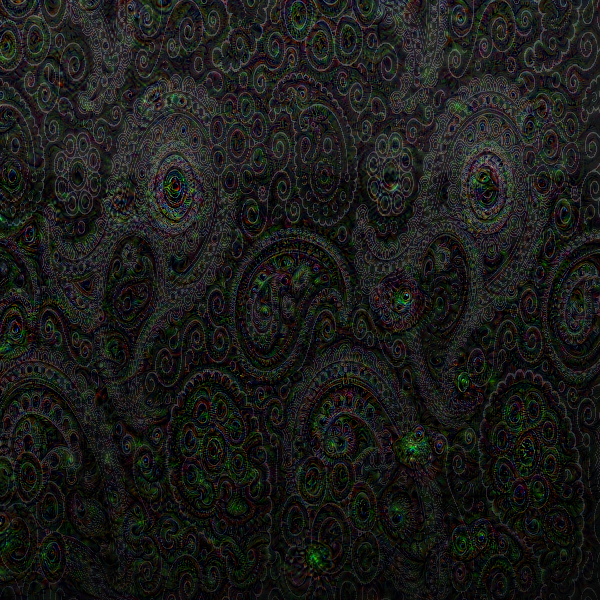

In [0]:
deepDreamRecursive(image)

# Neural-Style Audio Transfer

In [0]:
def read_audio_spectum(filename):
  x, fs = librosa.load(filename, duration=58.04) # Duration=58.05 so as to make sizes convenient
  S = librosa.stft(x)
  p = np.angle(S)
  S = np.log1p(np.abs(S))  
  return S, fs

In [0]:
style_audio, style_sr = read_audio_spectum("guitar.mp3")
content_audio, content_sr = read_audio_spectum("tabla.mp3")
#output_audio, output_sr = read_audio_spectum(output_audio_name)

In [0]:
style_sr,content_sr

(22050, 22050)

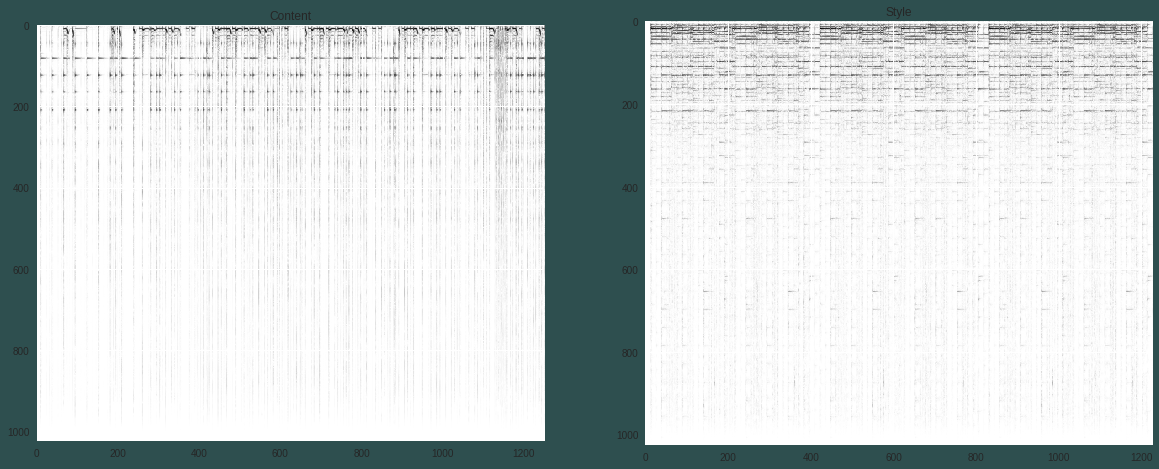

In [0]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(20,20),facecolor=(.18, .31, .31))
ax1.set_title('Content')
ax1.imshow(content_audio)
ax2.set_title('Style')
ax2.imshow(style_audio)

In [0]:
class AudioModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv1d(1025,4096,3)
    
  def forward(self ,x):
    out = self.conv1(x)
    return out

In [0]:
content_audio.shape , style_audio.shape

((1025, 1250), (1025, 1228))

In [0]:
a = torch.randn(5,6,7)

In [0]:
a.view(a.shape[0] , -1).shape

torch.Size([5, 42])

In [0]:
a = style_audio.reshape([1,1025,1228])
a = torch.from_numpy(a)
a = a.to(device)

In [0]:
c = AudioModel()
c.to(device)
d = c(a)

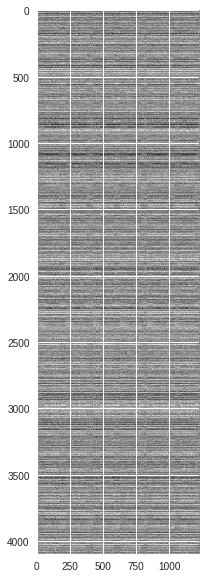

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(d.detach().to("cpu").numpy().squeeze())

In [0]:
c.conv1.weight.shape

torch.Size([4096, 1025, 3])

In [0]:
rm *.jpg *.jpg.1

TypeError: ignored

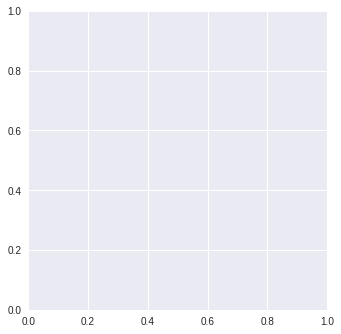

In [8]:
from 